# Speech Recognition with Conformers

In this homework problem, we will train a Conformer on the SpeechCommand dataset to perfrom ASR (automated speech recognition) and understand how it works by running various ablation studies on the architecture. The original paper is titled "Conformer: Convolution-augmented Transformer for Speech Recognition" and can be found here: https://arxiv.org/pdf/2005.08100.pdf. The setup was mostly adapted from this PyTorch tutorial on how to train a model using torchaudio: <br>
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/63ef278c9730746362d08162a440df77/speech_command_classification_with_torchaudio_tutorial.ipynb#scrollTo=ym0Ld-JqJeM_

# Setup

First we import any neccessary libraries, including the torchaudio library which is useful for audio-related deep learning tasks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

Check if a CoLab GPU is available and use it if so. This will make training the model much faster. If GPU is not enabled, please go to "Runtime -> Change Runtime Type -> GPU" to enable a GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

We import the SpeechCommands dataset using torchaudio. This is a dataset of 35 commands spoken by different people, with each audio file around 1 second long. We create a subclass to split the data into training, validation, and testing sets and torchaudio automatically converts the data into tensors

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

Let's take a look at the data. Each point in the dataset is a tuple consisting of


*   Waveform (Shape [1, N] where N is the signal value)
*   Sample rate (int)
*   Label (str, the command being spoken)
*   Speaker ID (str)
*   Utterance number (int)

We plot the waveform for the first tuple below, notice that it looks like an audio signal of someone speaking a single word

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Here's a list of all the labels (i.e. commands) that are spoken in the dataset

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

Listen to the first and last audio signals. It should sound like someone saying the words "Marvin" and "Visual"

In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [ ]:
waveform_second, *_ = train_set[-1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

Now we format the data to be used in training our conformer.  For the waveform, we downsample the audio for faster processing. We also use the sorted list of labels we constructed earlier to index each label, i.e. encoding it as an int

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

In [ ]:
for i in range(20):
  print("Shape of waveform #" + str(len(train_set)-i) + ": " + str(train_set[-i][0].shape))

Now, notice that the shapes of some of our waveforms are different across our dataset. We need to pad the waveforms with zeros until all of them have the same length. We use PyTorch's rnn.pad_sequence method to do the padding.

Now comes a bit of signal processing technical details. We transform the waveforms into a Mel Spectrogram. What does this mean? Read this article if you want the details: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53 but essentially it involves mapping the audio signal from the time domain to the frequency domain using FFT (fast fourier transform) then mapping these frequencies onto the Mel Scale to form a spectrogram. The Mel Scale is the result of some non-linear transformation to the frequency scale that is differentiable by the human ear. Sounds of equal distance on the Mel Scale "sound" to humans like they are of equal distance.

We kill two birds with one stone using the collate_fn function, which is explained here: https://pytorch.org/docs/stable/data.html#working-with-collate-fn. collate_fn is passed as an argument to dataloader which converts the dataset into an iterable. collate_fn allows us to modify the data before it is returned from the iterator, so we can perform the Mel transformation and padding in one go

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    #batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    #return batch.permute(0, 2, 1)
    return batch


def collate_fn(batch):
    # Function to transform waveform into mel spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=8000,n_mels=80)
    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices, store pre-padded sequence lengths
    tensorLengths = []
    for waveform, _, label, *_ in batch:
        waveform = torch.t(transform(waveform)[0])
        tensorLengths += [waveform.shape[0]]
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)

    targets = torch.stack(targets)

    return tensors, torch.LongTensor(tensorLengths), targets


batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Training the Conformer

Now we train the conformer on the formatted SpeechCommand dataset. We
import the Conformers model from torchaudio and initialize the model. We use the Adam optimizer with NLLLoss (negative log likelihood loss). The model outputs the log probabilities for each class in a tensor of shape [batch_size, num_classes]

In [ ]:
from torch.optim import Adam

############### TODO ###################
# Experiment with the hyperparameters
num_heads = 4
num_encoder_layers = 5
depthwise_conv_kernel_size = 11

######################################

# Define the model 
class ConformerNet(nn.Module):
  def __init__(self,num_classes, input_dim, encoder_dim, encoder_layers, heads, kernel_size, convolution_first):
    super().__init__()
    self.encoder = torchaudio.models.Conformer(input_dim=input_dim, num_heads=heads, ffn_dim=encoder_dim, num_layers=encoder_layers, depthwise_conv_kernel_size=kernel_size, convolution_first=convolution_first)
    self.fcDec = nn.LSTM(80, 81, 1, proj_size=35)


  def forward(self, inputs, input_lengths):
    encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
    outputs = encoder_outputs.permute(1,0,2)
    outputs = self.fcDec(outputs)[1][0][0]
    outputs = nn.functional.log_softmax(outputs, dim=-1)

    return outputs, encoder_output_lengths

model = ConformerNet(num_classes=len(labels), input_dim=80,encoder_dim=128,encoder_layers=num_encoder_layers, heads=num_heads, kernel_size=depthwise_conv_kernel_size, convolution_first=False).to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# Define the loss function
loss_fn = nn.NLLLoss()

In [ ]:
def train(model, num_epochs, interval):
  loss_epochs = []
  for epoch in range(1, num_epochs+1):
    losses = []
    for batch_idx, (input, inputLengths, targets) in enumerate(train_loader):
        input = input.to(device)
        inputLengths = inputLengths.to(device)
        targets = targets.to(device)

        # model takes in input of shape [batch_size, padded_seq_length, input_dim] and inputLengths of shape [batch_size]
        outputs, outputLengths = model(input, inputLengths)

        #NLLLoss
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print training stats
        if batch_idx % interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(input)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        losses.append(loss.item())
    loss_epochs.append(losses)
  return loss_epochs   

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def predict(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    num_correct = 0
    accuracy = []
    num_done = 0
    with torch.no_grad():
      for input, inputLengths, target in test_loader:

          data = input.to(device)
          dataLengths = inputLengths.to(device)
          target = target.to(device)

          output, outputLengths = model(data, dataLengths)

          pred = predict(output)
          num_correct += number_of_correct(pred, target)
          num_done += 1
          accuracy.append(num_correct/num_done)

      print(f"\nTest Epoch: {epoch}\tAccuracy: {num_correct}/{len(test_loader.dataset)} ({100. * num_correct / len(test_loader.dataset):.0f}%)\n") 

    return accuracy         

Run the cell below to train the Conformer. It should take about 3 minutes to finish. We store the losses for each batch and epoch and plot them below. 

In [ ]:
n_epochs = 1
interval = 40
loss_epochs = train(model, n_epochs, interval)

In [ ]:
for i in range(0, n_epochs):
  plt.plot(loss_epochs[i])
  plt.title("Epoch " + str(i+1))
  plt.ylabel("Training Loss")
  plt.xlabel("Batch Number")
  plt.show()

In [ ]:
accuracy = test(model, n_epochs)
for i in range(0, n_epochs):
  plt.plot(accuracy)
  plt.title("Epoch " + str(i+1))
  plt.ylabel("Testing Accuracy")
  plt.xlabel("Batch Number")
  plt.show()

**Answer the questions below and submit your answers with the written portion of the homework**

## Question 1

(a) Experiment with the parameters used to create the Conformer encoder:
*   encoder_dim
*   num_encoder_layers
*   depthwise_conv_kernel_size

**In general, does increasing any of the parameters give better performance?**

(b) Notice that the model takes in an argument called "input_lengths," which contains the lengths of the non-padded sequences for elements in the batch. Why does the conformer encoder need this information? Which part of the pipeline is this most important for?


(c) What does the decoder consist of for this model? What is contained in the final outputs of the model? *Hint: Look at what additional layers are defined in the conformer model after the encoder*




# Ablation Studies

We will now perform two ablation studies on the Conformer model. Ablation involves tampering with a single part of the architecture to see how it influences the model as a whole. This helps us understand the contribution of that part to the model. In the following problems, we will tamper with the number of heads in the attention layers and the order of the convolution and attention modules


<img src="https://user-images.githubusercontent.com/42150335/105602364-aeafad80-5dd8-11eb-8886-b75e2d9d31f4.png" alt="Drawing" width="500" height="500"/>

## Question 2

Recall the conformer block archietecture shown above. The multi-head self attention module (MHSA) helps the model capture long-term dependencies. The torchaudio.models implementation of the Conformer encoder has a parameter "num_heads" which controls how many heads are in the MHSA module

In [ ]:
heads = [1,5,10]
models = [ConformerNet(num_classes=len(labels), input_dim=80,encoder_dim=32,encoder_layers=5, heads=i,kernel_size=11, convolution_first=False).to(device) for i in heads]

Run the code below to train and test conformer models with various heads and look at the plots to see how the losses and testing accuracies change with the number of heads

In [ ]:
n_epochs = 1
interval = 40
losses = []
accuracies = []
for i in range(len(models)):
  model = models[i]
  print("\nTraining Conformer model with " + str(heads[i]) + " heads\n")
  losses.append(train(model, n_epochs, interval))
  print("\nTesting Conformer model with " + str(heads[i]) + " heads\n")
  accuracies.append(test(model, n_epochs))

In [ ]:
for i in range(0, len(losses)):
  plt.plot(losses[i][0])
  plt.title("Model with " + str(heads[i]) + " heads")
  plt.ylabel("Training Loss")
  plt.xlabel("Batch Number")
  plt.show()

In [ ]:
for i in range(0, len(accuracies)):
  plt.plot(accuracies[i])
  plt.title("Model with " + str(heads[i]) + " heads")
  plt.ylabel("Testing Accuracy")
  plt.xlabel("Batch Number")
  plt.show()

If you're having trouble finding the differences in the plots, we have attached a figure from the Conformers paper where this ablation study on the number of heads is done on the LibriSpeech dataset. The "dev" dataset contains the training data and the "test" set is the testing dataset. The numbers in the table represent the word-error rate (WER) which is the number of errors divided by the total number of words. The lower the WER, the more accurate the model

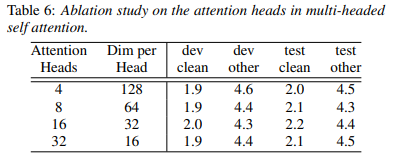

(a). How does increasing the number of heads in the conformer encoder influence the performance, i.e. the loss rates? Can you give an intuitive explanation as to why?

(b). In language prediction, multiple heads capture different dependencies in the input text such as subject-verb relationships and pronoun references. What is the audio analog of this idea? In other words, what kind of information do the different heads capture about the audio signal?

## Question 3

Now we run the ablation study switching the order of the conformer and MHSA attention modules. Again, the torchaudio implementation of the Conformer encoder takes in a parameter called "convolution_first." If this argument is set to true, the convolution module will occur before the attention module. If set to false, as we have been doing so far according to the original architecture, the attention module will appear first

In [ ]:
model_conv_first = ConformerNet(num_classes=len(labels), input_dim=80,encoder_dim=128,encoder_layers=5, heads=4, kernel_size=11, convolution_first=True).to(device)
model_attn_first = ConformerNet(num_classes=len(labels), input_dim=80,encoder_dim=128,encoder_layers=5, heads=4, kernel_size=11, convolution_first=False).to(device)


In [ ]:
n_epochs = 1
interval = 40
print("Training the Conformer with convolution module first:")
loss_conv = train(model_conv_first, n_epochs, interval)
print("\nTesting the Conformer with convolution module first:")
accuracy_conv = test(model_conv_first, n_epochs)
print("\nTraining the Conformer with attention module first:")
loss_attn = train(model_attn_first, n_epochs, interval)
print("\nTesting the Conformer with attention module first:")
accuracy_attn = test(model_attn_first, n_epochs)

In [ ]:
# Plot the losses
plt.plot(loss_conv[0])
plt.title("Model with convolution first")
plt.ylabel("Training Loss")
plt.xlabel("Batch Number")
plt.show()

plt.plot(loss_attn[0])
plt.title("Model with attention first")
plt.ylabel("Training Loss")
plt.xlabel("Batch Number")
plt.show()

In [ ]:
# Plot the testing accuracies
plt.plot(accuracy_conv)
plt.title("Model with convolution first")
plt.ylabel("Testing Accuracy")
plt.xlabel("Batch Number")
plt.show()

plt.plot(accuracy_attn)
plt.title("Model with attention first")
plt.ylabel("Testing Accuracy")
plt.xlabel("Batch Number")
plt.show()

If you're having trouble finding the differences in the plots, here is a figure from the Conformers paper where this ablation study was performed. The numbers in the table are once again the WER.

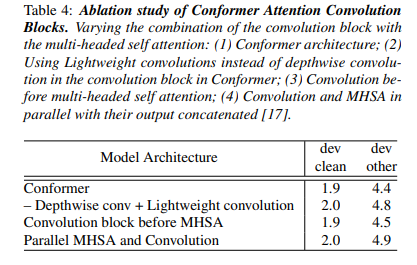

(a). Did one model perform better than the other, either the one with the convolution module first or the one with the self attention module first? 

(b). In the original paper, the authors also tried to split the input into parallel branches of a multi-headed self attention module and a convolution module with their output concatenated, which yielded worse performance. What does this tell you about the best architecture design for the Conformer block?